In [1]:
train_dir = 'D:/Perkuliahan/S2/Semester 4/google_images/jatengdiy_class_colab/train/'
test_dir = 'D:/Perkuliahan/S2/Semester 4/google_images/jatengdiy_class_colab/test/'

In [2]:
#Number of images to load at each iteration
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator

img_height, img_width = 224,224

batch_size = 32

train_datagen =  ImageDataGenerator(rescale=1./255)
test_datagen =  ImageDataGenerator(rescale=1./255)

# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(train_dir,target_size = (img_height, img_width),
                                                    batch_size = batch_size,class_mode = "categorical",
                                                    shuffle=True)

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(test_dir,target_size = (img_height, img_width),
                                                 batch_size = batch_size,class_mode = "categorical",
                                                 shuffle=False)

Total number of images for "training":
Found 9649 images belonging to 3 classes.
Total number of images for "testing":
Found 2412 images belonging to 3 classes.


In [3]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 
from keras.applications.vgg16 import preprocess_input
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Dropout
from tensorflow import keras
from keras.models import Sequential

In [4]:
# Checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint_filepath = 'D:/My Scripts/Github/Poverty Estimation/VGG16/Dropout_Model.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 1e-5, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, model_checkpoint_callback]

In [5]:
# Base Model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in conv_base.layers[:15]:
    layer.trainable=False

for layer in conv_base.layers[15:]:
    layer.trainable=True

In [6]:
model_drop = Sequential()
model_drop.add(conv_base)
model_drop.add(Flatten(name='flatten'))
model_drop.add(Dropout(0.5))
model_drop.add(Dense(32, name='my_dense', activation = 'relu'))
model_drop.add(Dropout(0.5))
model_drop.add(Dense(3, activation='softmax'))
model_drop.summary()

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_drop.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 my_dense (Dense)            (None, 32)                802848    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 15,517,635
Trainable params: 7,882,371
Non

In [7]:
history_drop = model_drop.fit(train_generator, epochs=100, shuffle=True, 
                              validation_data=test_generator, callbacks=callbacks, 
                              verbose=1)

Epoch 1/100
302/302 [==============================] - ETA: 0s - loss: 0.9164 - accuracy: 0.5416
Epoch 1: val_loss improved from inf to 0.73786, saving model to D:/My Scripts/Github/Poverty Estimation/VGG16\Dropout_Model.h5
302/302 [==============================] - 55s 158ms/step - loss: 0.9164 - accuracy: 0.5416 - val_loss: 0.7379 - val_accuracy: 0.6439
Epoch 2/100
302/302 [==============================] - ETA: 0s - loss: 0.7477 - accuracy: 0.6582
Epoch 2: val_loss improved from 0.73786 to 0.67790, saving model to D:/My Scripts/Github/Poverty Estimation/VGG16\Dropout_Model.h5
302/302 [==============================] - 49s 161ms/step - loss: 0.7477 - accuracy: 0.6582 - val_loss: 0.6779 - val_accuracy: 0.6787
Epoch 3/100
302/302 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.6748
Epoch 3: val_loss improved from 0.67790 to 0.60382, saving model to D:/My Scripts/Github/Poverty Estimation/VGG16\Dropout_Model.h5
302/302 [==============================] - 51s 168ms

In [8]:
import matplotlib.pyplot as plt 
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

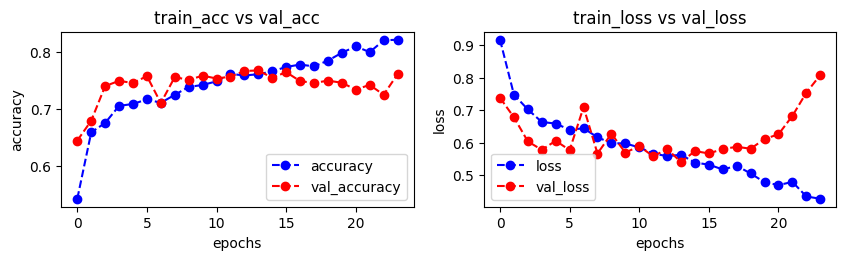

In [9]:
plot_accuracy_loss(history_drop)

In [10]:
score_drop = model_drop.evaluate(test_generator, verbose=0)
print(score_drop)

[0.5405691266059875, 0.7669983506202698]


In [11]:
import pandas as pd
hist_df = pd.DataFrame(history_drop.history)
hist_df.to_excel('D:/My Scripts/Github/Poverty Estimation/VGG16/Dropout_Model.xlsx')

In [7]:
import numpy as np
npzfile = np.load('D:/Perkuliahan/S2/Semester 4/nightlight.npz')
print(npzfile.files)
top_left_x_coords = npzfile['top_left_x_coords']
top_left_y_coords = npzfile['top_left_y_coords']
bands_data = npzfile['bands_data']

['top_left_x_coords', 'top_left_y_coords', 'bands_data']


In [10]:
from keras.models import Model
model_drop.load_weights('D:/My Scripts/Github/Poverty Estimation/VGG16/Dropout_Model.h5')
model_select = Model(inputs=model_drop.input, outputs=model_drop.get_layer('my_dense').output)

In [11]:
import os

def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

images_name = {} 
for i in range(64):
    dir_ = 'D:/Perkuliahan/S2/Semester 4/google_images/jatengdiy/' + str(i) + '/'
    image_files = os.listdir(dir_)
    for f in image_files:
        images_name[f] = i

def get_input_feature_2(img_path):
    # img = image.load_img(img_path, target_size=(400, 400))
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #features = model_old.predict(x)
    pool_features = model_select.predict(x)
    return pool_features[0]

def get_daytime_feature(sample):
    idx, wealth, x, y = sample
    print(idx)
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    left_idx = lon_idx - 23
    right_idx = lon_idx + 22
    up_idx = lat_idx - 23
    low_idx = lat_idx + 22
    features_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            file_name = str(i) + '_' + str(j) + '.jpg'
            if file_name in images_name:
                luminosity = images_name[file_name]
                feature = get_input_feature_2('D:/Perkuliahan/S2/Semester 4/google_images/jatengdiy/' + str(luminosity) + '/' + file_name)
                features_100.append(feature)
    if len(features_100) == 0:
        print('nononono: ' + str(idx))
        return np.asarray([np.nan] * 32 + [wealth]).tolist()
    else:
        features_100 = np.asarray(features_100)
        return np.append(np.mean(features_100, axis=0), wealth).tolist()

In [12]:
import pandas as pd
from keras.preprocessing import image
clusters = pd.read_excel('D:/Perkuliahan/S2/Semester 4/jatengdiy_coord.xlsx', sheet_name='tableau')
clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['Wadmkk'], x['Pengeluaran'], x['Longitude'], x['Latitude']]), axis=1)

data_all = clusters['feature']
data_all = np.asarray([i for i in data_all])
data_all = data_all[~np.isnan(data_all).any(axis=1)]

df = pd.DataFrame(data_all)
df.to_excel('D:/My Scripts/Github/Poverty Estimation/VGG16/Dropout Model Extracted.xlsx')

Banjarnegara
Bantul
Banyumas
Batang
Blora
Boyolali
Brebes
Cilacap
Demak
Grobogan
Gunungkidul
Jepara
Karanganyar
Kebumen
Kendal
Klaten
Kota Magelang
Kota Pekalongan
Kota Salatiga
Kota Semarang
Kota Surakarta
Kota Tegal
Kota Yogyakarta
Kudus
Kulon Progo
Magelang
Pati
Pekalongan
Pemalang
Purbalingga
Purworejo
Rembang
Semarang
Sleman
Sragen
Sukoharjo
Tegal
Temanggung
Wonogiri
Wonosobo
